# AI back test methods1

# --2 fonctions and dependancys


In [1]:
#! python3 -m pip install --upgrade pip
#! pip install mplfinance
from xdata_config import *
from functions_module import *
import mplfinance as mpf
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import MaxNorm
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense 
from keras.models import load_model
from datetime import datetime

/usr/local/lib/python3.9/dist-packages/pandas/core/arrays/masked.py:59: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (
2023-03-20 23:18:32.593407: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 23:18:32.593469: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 23:18:32.715875: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-20 23:18:36.667991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: N

In [2]:
import requests

url = 'https://api.binance.com/api/v3/ticker/price'

response = requests.get(url)
tickers = response.json()
ticker_list=[]
for ticker in tickers:
    ticker_list.append((ticker['symbol']))


# --1 Config

In [14]:
# ai_options
Normalization_File= "False"
Model_FileName= "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5"
WINDOW_SIZE= 7
PRESSISION=0.0
PERIODE_START="2023-02-09 00:00:00"
PERIODE_END="2023-02-11 00:00:00"

# start_period = datetime.strptime(PERIODE_START, '%d-%m-%Y %H:%M:%S')
# end_period = datetime.strptime(PERIODE_END, '%d-%m-%Y %H:%M:%S')
start_period = pd.Timestamp(PERIODE_START)
end_period = pd.Timestamp(PERIODE_END)


#trading_options:
TAKE_PROFIT= 0.4  
STOP_LOSS=  0.8 
MAX_HOLDING_TIME= 16

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  

PAIR_WITH= "USDT"
TRADE_TOTAL= 100 
TRADE_SLOTS= 5

TRADING_FEE= 0.1
  

# --3 Importing DATA

In [4]:
from datetime import date
#TICKERS = "../Binance-Fast-Trade-Bot/volatile_volume_" + str(date.today()) + ".txt"
TICKERS = "/UltimeTradingBot/Binance-Fast-Trade-Bot/halal_coins.txt"
VOLATILE_COINS=[line.strip() for line in open(TICKERS)]
PAIR_WITH="USDT"
VOLATILE_USDT_PAIRS=[coin+"/USDT" for coin in VOLATILE_COINS]
VOLATILE_BUSD_PAIRS=[coin+"/BUSD" for coin in VOLATILE_COINS]
for pair in VOLATILE_BUSD_PAIRS:
    if pair.replace('/' ,'') not  in ticker_list:
        print(pair)
        VOLATILE_BUSD_PAIRS.remove(pair)

for pair in VOLATILE_USDT_PAIRS:
    if pair.replace('/', '') not in ticker_list:
        print(pair)
        VOLATILE_USDT_PAIRS.remove(pair)

content = os.listdir('database/DataBackTest/1m')
for pair in VOLATILE_USDT_PAIRS:
    if pair.replace('/', '-')+'.csv' not in content:
        print(pair)
        VOLATILE_USDT_PAIRS.remove(pair)
for pair in VOLATILE_BUSD_PAIRS:
    if pair.replace('/', '-')+'.csv' not in content:
        print(pair)
        VOLATILE_BUSD_PAIRS.remove(pair)

MTD/BUSD
SNM/USDT
IQ/USDT
MTD/USDT
SNM/USDT
UST/USDT
BTG/USDT
EPS/USDT
DNT/USDT
UST/BUSD
BTG/BUSD
EPS/BUSD
DNT/BUSD


In [ ]:
# coins_to_download=''
# for coin in LISTCOIN:
#     coins_to_download=coins_to_download+" "+coin
# os.system(f"node database/dd_for_backtest.js {coins_to_download} {PAIR_WITH}")#node database/ddargs.js ORN BUSD

In [5]:
pair_list = VOLATILE_USDT_PAIRS
#tf = '1m'
oldest_pair = "BTC/USDT"
if oldest_pair not in pair_list: pair_list.append(oldest_pair)
df_list1m = {}
df_list1d = {}
df_list1h = {}
df_list5m = {}
df_list15m = {}


for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1m', path="./database/")
    df_list1m[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1d', path="./database/")
    df_list1d[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '1h', path="./database/")
    df_list1h[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(ccxt.binance(), pair, '5m', path="./database/")
    df_list5m[pair] = df.loc[:]

for pair in pair_list:
    df = get_backtest_historical(
        ccxt.binance(), pair, '15m', path="./database/")
    df_list15m[pair] = df.loc[:]
del(df)
df_list = df_list1m
prerr("Data load 100% use df_list1d[\"BTC/USDT\"] for exemple to access")



In [45]:
def buy_optimal(df,BUY_PCT=BUY_PCT,SELL_PCT=SELL_PCT,window=MAX_FORCAST_SIZE):
    #df = df.fillna(0)
    mino = BUY_PCT / 100.0
    maxo = SELL_PCT / 100.0
    
    max_forecast_size=window#MAX_FORCAST_SIZE
    try:
        after_dip_val=AFTER_MARK
    except:
        after_dip_val=0
    print(f"after mark = : {after_dip_val}")
    try:
        print(f"optimalbuy buy maximum forcast size={max_forecast_size} at {BUY_PCT}% of the current price ")
    except:
        max_forecast_size = 3
        print("optimalbuy buy default window=3")
        
    rolling_max_close_diff = ((df['close'].rolling(window=window).max().shift(-window+1) / df['close']) - 1).fillna(0)
    df['buy']=(rolling_max_close_diff >= mino).astype(int)
    
    # Compute rolling minimum values
    
    window_list=[7,window]#[3, 5, 7, 10, 15, 20]
    
    for window_size in window_list:
        col_name = f'ismin{window_size}'
        rolling_min = (df['close'].shift(after_dip_val) <= df.shift(-window_size-1)['close'].rolling(2*window_size).min())
        df = df.assign(**{col_name: rolling_min.astype(int)})

    df['ismin'] = df[[f'ismin{window_size}' for window_size in window_list ]].any(axis=1).astype(int)        

    # # Compute buy and sell signals
    rolling_low_close_diff =  ((df['low'].rolling(window=int(window/2)).min().shift(-int(window/2)+1)/ df['close'] ) -1).fillna(0)
    df['sell'] = (rolling_low_close_diff <= -maxo).astype(int)

    
    # Compute final buy signal
    df['buy'] = ((df['buy'] == 1) & (df['sell'] == 0) & (df['ismin'] == 1)).astype(int)
    # Remove unnecessary columns
    df = df.drop(columns=['sell', 'ismin'] + [f'ismin{window_size}' for window_size in window_list], errors='ignore')
    return df

after mark = : 1
optimalbuy buy maximum forcast size=20 at 0.5% of the current price 


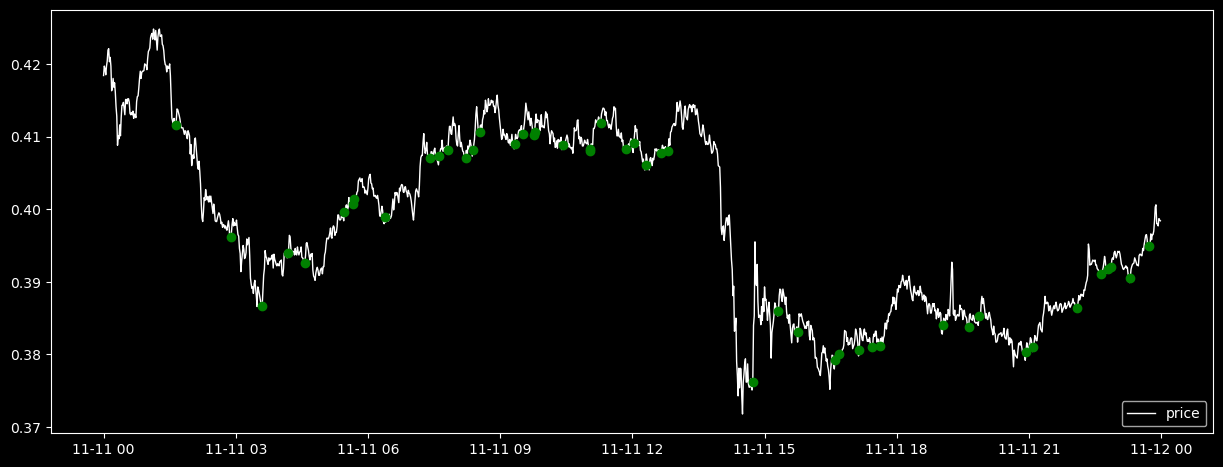

In [46]:
df=df_list1m["GMT/USDT"]
df=buy_optimal(df,BUY_PCT=0.5,SELL_PCT=0.3,window=20)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5.5)

x = np.linspace(0, 10, 500)
dashes = []#[10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

fig, ax = plt.subplots()
line1, = ax.plot(df.index[i_start:i_end], df.close[i_start:i_end], '-', linewidth=1,
                 label='price',c="w")
line1.set_dashes(dashes)

plt.plot(df[i_start:i_end][df.buy[i_start:i_end]==1].index, df[i_start:i_end][df.buy[i_start:i_end]==1].close, 'ro',c='g')

ax.legend(loc='lower right')
plt.show()



# --4 Initial Test

mini_expand : ETC/USDT
after mark = : 1
optimalbuy buy maximum forcast size=7 at 0.4% of the current price 
Precent Mean: 1.675%
######################  mini_expand5 ETC/USDT - shape (2865, 607)  buy mean : 1.675 ############################
False
False
Buy mean pct: 1.675%
Precent Mean: 10000.000%


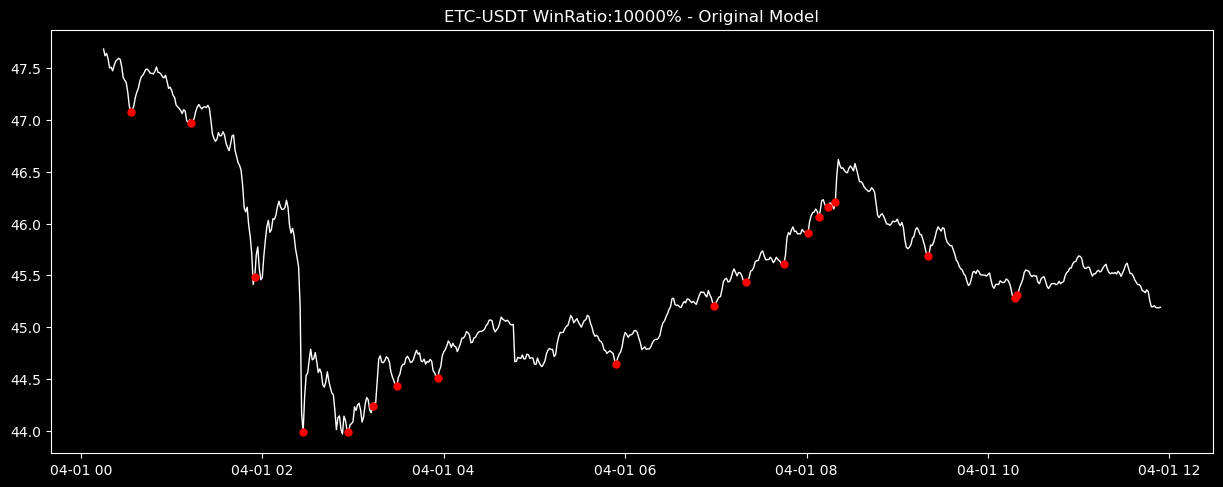

In [51]:
## Generate Data
BAD_PERIOD_START="2022-08-30"
BAD_PERIOD_END="2023-01-22"
pair_to_test="ETC/USDT"
MAX_FORCAST_SIZE=20

# ai_options
WINDOW_SIZE= 15
PERIODE_START="2023-02-09 00:00:00"
PERIODE_END="2023-02-11 00:00:00"

start_period = pd.Timestamp(PERIODE_START)#datetime.strptime(PERIODE_START, '%d-%m-%Y %H:%M:%S')
end_period = pd.Timestamp(PERIODE_END)


#trading_options:
TAKE_PROFIT= 0.4
STOP_LOSS=  3.3  
MAX_HOLDING_TIME= MAX_FORCAST_SIZE

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  





loc_start=100
loc_end=100000


i_start=0
i_end=i_start+1440

loc_start=df_list1m[pair_to_test].index.get_loc(start_period) #df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
loc_end=df_list1m[pair_to_test].index.get_loc(end_period)


OnePair_DF=mini_expand5(        pair=pair_to_test,
                                i=loc_start,j=loc_end,
                                window=WINDOW_SIZE,
                                metadata=MetaData,
                                high_weight=1,
                                BUY_PCT=TAKE_PROFIT,
                                SELL_PCT=STOP_LOSS,
                                buy_function=buy_optimal#buy_test2#buy_minimum#buy_fix#buy_test
                        )
OnePair_DT=OnePair_DF.to_numpy()
gc.collect()
OnePair_DT=fixdt(OnePair_DT)
print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
hp(OnePair_DF.buy.mean(),"Buy mean pct")


## Ploting original
plot_data("Original Model", pair_to_test, 100, OnePair_DF, i_start, 700, OnePair_DF.buy,dot_color="r")


In [ ]:
# # df_list1m["LTC/USDT"].pop("buy0")
# # df_list1m["LTC/USDT"].pop("buy1")
# # df_list1m["LTC/USDT"].pop("sell0")

# OnePair_DF.pop("buy0")
# OnePair_DF.pop("buy1")
# OnePair_DF.pop("sell0")


2023-03-21 03:00:19.137024: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-21 03:00:19.138012: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-21 03:00:19.138652: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: abj-K93SV
2023-03-21 03:00:19.138689: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: abj-K93SV
2023-03-21 03:00:19.139661: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-03-21 03:00:19.140935: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.154.0


Precent Mean: 10000.000%


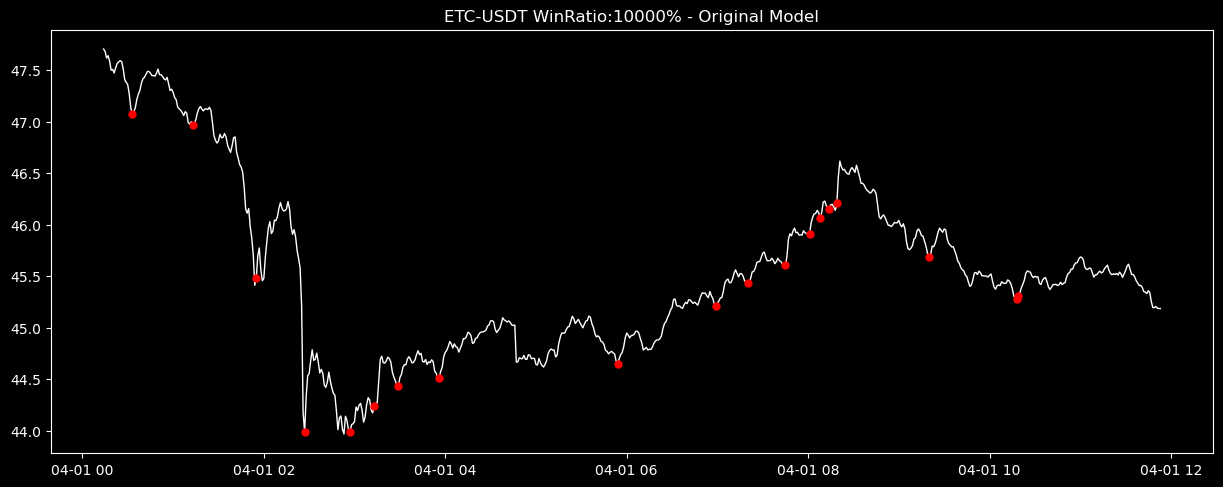

ValueError: in user code:

    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.9/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.9/dist-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 606), found shape=(None, 566)


In [49]:
# Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re3.h5" #LTC ::80.99/0.86 # GMT: 84/0.93 LPT:86.9330453563715/0.8 ETH:78 #SOL 75/0.6 Doge:58/0.5


# # Model_FileName= "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp349_w12_max12min_Model_VeryDeep.h5" # Win Ratio:47.11246200607903 # GMT  Win Ratio:57.608695652173914
# #Model_FileName= "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp250_w12_max12min_Model_VeryDeep.h5" # Win Ratio:42.80420927819772 #GMT Win Ratio:53.
# #Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp180_w12_max12min_Model_VeryDeep.h5" # Win Ratio:59.35050391937291 # GMT 61.70886075949367/9 #SNM 52% / ETH 59.8/2
# #Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp70_w12_max12min_Model_VeryDeep.h5" # %44
# # Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp300_w12_max60min_Model_true_win_model_v2.h5" #45%
# #Model_FileName="/UltimeTradingBot/Data/BUY_TEST/tp300_w12_max60min_Model_VeryDeep.h5" #46%

#Model_FileName="/UltimeTradingBot/Data/BUY_OPTIMAL/tp40_w14_max7min_Anti-Model_v2.h5"
Model_FileName="../Data/BUY_OPTIMAL/tp92_w15_max7min_Model_true_win_model_Re6.h5"
USED_MODEL=load_model(Model_FileName)




plot_data("Original Model", pair_to_test, 100, OnePair_DF, i_start, 700, OnePair_DF.buy,dot_color="r")





OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
OnePair_Pred=OnePair_PredNote.round()

gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
buy_mean=hp(Original_Traget_Data.mean(),"Buy Mean: ")
Predicted_Data=OnePair_Pred[:,0]
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")
TestsHistory.loc[len(TestsHistory)]=[Model_FileName,pair_to_test ,ModelAccuracy, TrueWinPred_Mean, LossPred_Mean, MissedDeal_Mean, GoodZero_Mean, WINDOW_SIZE,MAX_FORCAST_SIZE,TAKE_PROFIT,hp(winratio),buy_mean]


PREDICTION_TO_TEST=Predicted_Data
plot_data(Model_FileName, pair_to_test, winratio, OnePair_DF, i_start, 700, PREDICTION_TO_TEST)

gc.collect()

In [ ]:
TestsHistory= pd.DataFrame(columns= ['Model-FileName','TestedPair' ,'ModelAccuracy', 'TrueWin', 'XLoss', 'MissedDeal', 'GoodZero', 'WINDOW','MAX_FORCAST_SIZE','TAKE_PROFIT','WinRatio','BuyMean'])

In [57]:
## Generate Data
BAD_PERIOD_START="2022-09-15"
BAD_PERIOD_END="2022-11-22"
MAX_FORCAST_SIZE=16

# ai_options
WINDOW_SIZE= 15

start_period = pd.Timestamp(BAD_PERIOD_START)
end_period = pd.Timestamp(BAD_PERIOD_END)


#trading_options:
TAKE_PROFIT= 0.4
STOP_LOSS=  1.3  
MAX_HOLDING_TIME= MAX_FORCAST_SIZE

USE_TRAILING_STOP_LOSS: False
TRAILING_STOP_LOSS= .002     
TRAILING_TAKE_PROFIT= .002  





loc_start=0
loc_end=1000000


i_start=0
i_end=i_start+1000

# loc_start=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_START))
# loc_end=df_list1m[pair_to_test].index.get_loc(pd.to_datetime(BAD_PERIOD_END))


Model_FileNames=["/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re3.h5" #LTC ::80.99/0.86 # GMT: 84/0.93 LPT:86.9330453563715/0.8 ETH:78 #SOL 75/0.6 Doge:58/0.5
,"/UltimeTradingBot/Data/BUY_TEST/tp30_w7_max2min_Model_VeryDeep.h5"   #52.500060887990465/21 ETC:51.307/16
,"/UltimeTradingBot/Data/BUY_TEST/tp30_w7_max2min_Model_true_win_model_Re1.h5"   #GMT 65.888/2% -  ETh: 55.0/0.37 -LTC 54/1.8
,"/UltimeTradingBot/Data/BUY_TEST/tp30_w7_max2min_Model_true_win_model_Re2.h5"
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re2.h5" #LTC: 64/4
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re1.h5" #LTC: 57.15/7.9
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_VeryDeep.h5" #LTC:48.741696716644526/12
,"/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_vInit.h5" #
,"/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_true_win_model_Re1.h5" #Doge:28/4.5
,"/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_true_win_model_Re2.h5" #Doge:32/4.0
,"/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_true_win_model_Re3.h5" #Doge:34.17/3.8 GMT35
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re2.h5" #LTC ::80.99/0.86 # GMT: 84/0.93 LPT:86.9330453563715/0.8 ETH:78 #SOL 75/0.6 Doge:58/0.5
,"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_true_win_model_Re3.h5" #GMT 44/
,"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_JUSTGood_v2.h5"
,"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_JUSTGood_v2.h5" # GMT:58/8
,"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re2.h5" #58/6
,"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Model_true_win_model_Re7.h5",
"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Anti-Model_v2.h5"

]

Model_FileNames=["/UltimeTradingBot/Data/BUY_TEST/tp92_w7_max3min_Model_true_win_model_Re4.h5",
                 "/UltimeTradingBot/Data/BUY_TEST/tp92_w7_max3min_Model_true_win_model_Re4.h5",
                 "/UltimeTradingBot/Data/BUY_TEST/tp92_w7_max3min_Model_VeryDeep.h5",
                 "/UltimeTradingBot/Data/BUY_TEST/tp92_w7_max3min_Model_vInit.h5"]

Model_FileNames=["/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re3.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re2.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re1.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_VeryDeep.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_vInit.h5"
    
]


Model_FileNames=matching_files
for pair_to_test in ["GMT/USDT","XRP/USDT","ETH/USDT","LTC/USDT","SOL/USDT"],"APE/USDT":
    coin=pair_to_test
    loc_start=df_list1m[coin].index.get_loc(start_period)
    loc_end=df_list1m[coin].index.get_loc(end_period)
    print(f'#################################################### Working on : {pair_to_test} ###################################################')
    OnePair_DF=mini_expand4(        pair=pair_to_test,
                                    i=loc_start,j=loc_end,
                                    window=WINDOW_SIZE,
                                    metadata=MetaData,
                                    high_weight=1,
                                    BUY_PCT=TAKE_PROFIT,
                                    SELL_PCT=STOP_LOSS,
                                    buy_function=buy_test
                            )
    OnePair_DT=OnePair_DF.to_numpy()
    gc.collect()
    OnePair_DT=fixdt(OnePair_DT)
    print(OnePair_DT[0,0] == OnePair_DF.iloc[0,0])
    print(OnePair_DT[5,5] == OnePair_DF.iloc[5,5])
    hp(OnePair_DF.buy.mean(),"Buy mean pct")
    x = np.linspace(0, 10, 500)
    dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

    fig, ax = plt.subplots()
    line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                    label='Dashes set retroactively')
    line1.set_dashes(dashes)
    plt.plot(OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].price, 'ro')


    ax.legend(loc='lower right')
    plt.show()


    for Model_FileName in Model_FileNames:
        print(f'Using Model:{Model_FileName}')
        USED_MODEL=load_model(Model_FileName)

  


        OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
        OnePair_Pred=OnePair_PredNote.round()

        gc.collect()

        Original_Traget_Data=OnePair_DT[:,-1]
        buy_mean=hp(Original_Traget_Data.mean(),"Buy Mean: ")
        Predicted_Data=OnePair_Pred[:,0]
        gc.collect()
        TruePred=(Original_Traget_Data==Predicted_Data).copy()
        ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
        gc.collect()
        TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
        TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
        gc.collect()
        LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
        LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
        gc.collect()

        MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
        MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
        gc.collect()

        GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
        GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
        gc.collect()

        fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
        if( fiability == 100):print("good fiability")
        else: print(f"check the fiability {fiability}")
        winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

        print(f"========= Win Ratio:{winratio*100} %====================")
        TestsHistory.loc[len(TestsHistory)]=[Model_FileName,pair_to_test ,ModelAccuracy, TrueWinPred_Mean, LossPred_Mean, MissedDeal_Mean, GoodZero_Mean, WINDOW_SIZE,MAX_FORCAST_SIZE,TAKE_PROFIT,hp(winratio),buy_mean]
        TestsHistory.to_csv("Plots/mini-results.csv")

        PREDICTION_TO_TEST=Predicted_Data

        x = np.linspace(0, 10, 500)
        dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
        fig, ax = plt.subplots()
        line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                        label='price')
        line1.set_dashes(dashes)
        plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro')
        mname=Model_FileName.replace("/UltimeTradingBot/Data","")
        mtitle=f"{coin} - {mname}".replace("/","-")
        plt.title(mtitle)
        plt.savefig(f"Plots/{mtitle}.png")        
        plt.show()
        gc.collect()

NameError: name 'day' is not defined

In [ ]:
TestsHistory2=TestsHistory

In [ ]:
TestsHistory=pd.read_csv("test-restuls01.csv",index_col=0)

In [ ]:
# TestsHistory.sort_values("WinRatio",ascending=0)[:30]
TestsHistory.sort_values("TestedPair",ascending=0)[:30]

In [ ]:
TestsHistory.sort_values("TrueWin",ascending=0)[:20]

In [ ]:
TestsHistory.groupby("Model-FileName").mean().sort_values("WinRatio",ascending=0)[:10]

In [ ]:
TestsHistory.groupby("Model-FileName").mean().sort_values("WinRatio",ascending=0)[:10]

# Test MultiModel sollution

In [ ]:

bag_of_modules=["/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Anti-Model_v2.h5",
               "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Model_VeryDeep.h5",
               "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_vInit.h5",
               "/UltimeTradingBot/Data/SELL_TEST/tp70_w7_max3min_Model_vInit.h5",
               #"/UltimeTradingBot/Data/BUY_TEST/tp150_w7_max2min_Model_true_win_model_v3.h5", 
               #"/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re1.h5"
               ]

bag_of_modules=[
                "/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Model_vInit.h5",
                #"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Model_true_win_model_Re8.h5",
                #"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp130_w7_max16min_Anti-Model_v2.h5",
                #"/UltimeTradingBot/Data/AFTER_DEPTH_CLOSE/tp42_w7_max16min_Model_vInit.h5",
                "/UltimeTradingBot/Data/BUY_MIN_CLOSE/tp70_w7_max4min_Model_VeryDeep.h5",
                "/UltimeTradingBot/Data/BUY_TEST/tp150_w7_max2min_Model_vInit.h5",  
 #               "/UltimeTradingBot/Data/SELL_TEST/tp250_w7_max16min_Model_vInit.h5", 
 #               "/UltimeTradingBot/Data/SELL_TEST/tp25_w7_max1min_Anti-Model_v2.h5",               
                ]

bag_of_modules=[
                # "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re3.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re4.h5",
                #  "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re2.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_true_win_model_Re1.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_VeryDeep.h5",
                 "/UltimeTradingBot/Data/BUY_FIX/tp80_w7_max3min_Model_vInit.h5"
    
]

aditive_models=["/UltimeTradingBot/Data/SELL_TEST/tp25_w7_max1min_Model_vInit.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp25_w7_max1min_Anti-Model_v2.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp40_w7_max3min_Anti-Model_v2.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp40_w7_max3min_Model_BadVeryDeep_v2.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp250_w7_max16min_Model_VeryDeep.h5",
                "/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_v5.h5",  
                "/UltimeTradingBot/Data/BUY_TEST/tp70_w7_max2min_Model_true_win_model_Re3.h5",
                "/UltimeTradingBot/Data/SELL_TEST/tp70_w7_max3min_Model_vInit.h5",
                
                              
                ]
aditive_models=[]
import matplotlib.pyplot as plt

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off

fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='Dashes set retroactively')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][OnePair_DF.buy[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()

OnePair_Pred=1
if aditive_models:
    for Model_FileName in aditive_models:
        USED_MODEL=load_model(Model_FileName)
        OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
        OnePair_Pred=(OnePair_PredNote.round()==1)|(OnePair_Pred==1)
if bag_of_modules:
    for Model_FileName in bag_of_modules:
        USED_MODEL=load_model(Model_FileName)
        OnePair_PredNote=USED_MODEL.predict( OnePair_DT[:, 0:-1])
        OnePair_Pred=OnePair_PredNote.round()*OnePair_Pred

gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
buy_mean=hp(Original_Traget_Data.mean(),"Buy Mean: ")
Predicted_Data=OnePair_Pred[:,0]
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")
TestsHistory.loc[len(TestsHistory)]=[Model_FileName,pair_to_test ,ModelAccuracy, TrueWinPred_Mean, LossPred_Mean, MissedDeal_Mean, GoodZero_Mean, WINDOW_SIZE,MAX_FORCAST_SIZE,TAKE_PROFIT,hp(winratio),buy_mean]


PREDICTION_TO_TEST=Predicted_Data

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()
gc.collect()

In [ ]:
ii_start=49000
ii_end=ii_start+1000
x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[ii_start:ii_end], OnePair_DF.price[ii_start:ii_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[ii_start:ii_end][PREDICTION_TO_TEST[ii_start:ii_end]==1].index, OnePair_DF[ii_start:ii_end][PREDICTION_TO_TEST[ii_start:ii_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()
gc.collect()

In [ ]:
ii_start=46000
ii_end=ii_start+600
x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[ii_start:ii_end], OnePair_DF.price[ii_start:ii_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[ii_start:ii_end][PREDICTION_TO_TEST[ii_start:ii_end]==1].index, OnePair_DF[ii_start:ii_end][PREDICTION_TO_TEST[ii_start:ii_end]==1].price, 'ro')


# ax.legend(loc='lower right')

plt.show()
gc.collect()

In [ ]:
!ls Plots

In [ ]:
press=-0.37
OnePair_Pred=(OnePair_PredNote+press).round()
gc.collect()

Original_Traget_Data=OnePair_DT[:,-1]
buy_mean=hp(Original_Traget_Data.mean(),"Buy Mean: ")
Predicted_Data=OnePair_Pred[:,0]
gc.collect()
TruePred=(Original_Traget_Data==Predicted_Data).copy()
ModelAccuracy=hp(TruePred.mean(),"ModelAccuracy")
gc.collect()
TrueWinPred=((Predicted_Data==1) & (Original_Traget_Data==1) ).copy()
TrueWinPred_Mean=hp(TrueWinPred.mean(),"True Win Predictions Mean of all")
gc.collect()
LossPred=((Predicted_Data==1) & (Original_Traget_Data==0) ).copy()
LossPred_Mean=hp(LossPred.mean(),"XXX Loss Buy Mean of all")
gc.collect()

MissedDealPred=((Predicted_Data==0) & (Original_Traget_Data==1) ).copy()
MissedDeal_Mean=hp(MissedDealPred.mean(),"Missed good deal off all")
gc.collect()

GoodZeroPred=((Predicted_Data==0) & (Original_Traget_Data==0) ).copy()
GoodZero_Mean=hp(GoodZeroPred.mean(),"Good Zero prediction Mean")
gc.collect()

fiability=TrueWinPred_Mean + LossPred_Mean + MissedDeal_Mean + GoodZero_Mean
if( fiability == 100):print("good fiability")
else: print(f"check the fiability {fiability}")
winratio=TrueWinPred_Mean/(LossPred_Mean+TrueWinPred_Mean)

print(f"========= Win Ratio:{winratio*100} %====================")
TestsHistory.loc[len(TestsHistory)]=[Model_FileName,pair_to_test ,ModelAccuracy, TrueWinPred_Mean, LossPred_Mean, MissedDeal_Mean, GoodZero_Mean, WINDOW_SIZE,MAX_FORCAST_SIZE,TAKE_PROFIT,hp(winratio),buy_mean]


PREDICTION_TO_TEST=Predicted_Data

x = np.linspace(0, 10, 500)
dashes = [10, 5, 100, 5]  # 10 points on, 5 off, 100 on, 5 off
fig, ax = plt.subplots()
line1, = ax.plot(OnePair_DF.index[i_start:i_end], OnePair_DF.price[i_start:i_end], '-', linewidth=1,
                 label='price')
line1.set_dashes(dashes)
plt.plot(OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].index, OnePair_DF[i_start:i_end][PREDICTION_TO_TEST[i_start:i_end]==1].price, 'ro')


ax.legend(loc='lower right')
plt.show()
gc.collect()

In [ ]:
TestsHistory[TestsHistory.WinRatio==78.558]["Model-FileName"].values

In [ ]:
TestsHistory[TestsHistory.WinRatio==60.909]

In [ ]:
TestsHistory.to_csv("test-restuls02.csv")

In [55]:
import os
import glob

path = "/UltimeTradingBot/Data"
patternw7 = os.path.join(path, "**/*w7*.h5")
patternw15 = os.path.join(path, "**/*w15*.h5")
patternw15Buy_opt = os.path.join(path, "BUY_OPTIMAL/*w15*.h5")
pattern=patternw15Buy_opt
matching_files = []
for file_path in glob.iglob(pattern, recursive=True):
    if os.path.isfile(file_path):
        matching_files.append(file_path)

print(matching_files)

['/UltimeTradingBot/Data/BUY_OPTIMAL/tp92_w15_max7min_Model_VeryDeep.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp92_w15_max7min_Model_true_win_model_Re1.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp150_w15_max7min_Anti-Model_v2.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp150_w15_max7min_Model_true_win_model_Re5.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp150_w15_max7min_Model_true_win_model_Re4.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp150_w15_max7min_Model_vInit.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp92_w15_max7min_Model_BadVeryDeep_v2.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp92_w15_max7min_Model_v5.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp150_w15_max7min_Model_true_win_model_Re6.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp150_w15_max7min_Model_v5.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp92_w15_max7min_Model_true_win_model_Re2.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp92_w15_max7min_Model_true_win_model_Re6.h5', '/UltimeTradingBot/Data/BUY_OPTIMAL/tp92_w15_max7min_Model_true_win